# LStein: Linking Series to envision information neatly
[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/TheRedElement/LStein/blob/main/LStein_demo/LStein_demo_colab.ipynb)

This is a minimal working jupyter notebook where you can play around with the current version of `LStein`

## Installation

Uncomment the line below to install `LStein` in your current environment!
If you run this notebook in [google colab](https://colab.google/), you should not need to install anything else.
You might, however, need to restart your session to have the required versions of [matplotlib](https://matplotlib.org/) and [numpy](https://numpy.org/) ready.

In [1]:
# !pip3 install git+https://github.com/TheRedElement/LStein.git

## Get Data

Uncomment if you run this notebook in [google colab](https://colab.google/).
This will download some example data into [./data/](./data).
The downloaded data (and some more examples) can be found in original [repo](https://github.com/TheRedElement/LStein/tree/main/data).

In [2]:
# !mkdir ./data
# !wget -O ./data/1189_snia_elasticc.csv https://github.com/TheRedElement/LStein/raw/refs/heads/main/data/1189_snia_elasticc.csv
# !wget -O ./data/0901_snii_elasticc.csv https://github.com/TheRedElement/LStein/raw/refs/heads/main/data/0901_snii_elasticc.csv
# !wget -O ./data/2025_tde_elasticc.csv https://github.com/TheRedElement/LStein/raw/refs/heads/main/data/2025_tde_elasticc.csv


To look at the head of the downloaded files in [google colab](https://colab.google/) uncomment the line below.
The head contains information about the columns.

In [3]:
# !head ./data/1189_snia_elasticc.csv

## Preliminary Setup

In [4]:
#%%imports
import matplotlib.pyplot as plt
import numpy as np
import polars as pl
from typing import Literal

from lstein import (
    utils as lsu,   #for coloring
    makedata as md  #for simulated data
)
from lstein import lstein   #main import

In [ ]:
#%%data loading
def gen_data(simtype:Literal["lc","sin"]):
    """
        - function to generate some data
    """
    xmin2zero = False   #whether to shift xvalues to start at 0

    #deal with on-the-fly data generation (pseudo filenames)
    if simtype == "lc":
        raw, pro = md.simulate(5, opt="lc")
        df = pl.concat([pl.from_dict(raw), pl.from_dict(pro)])
        thetalab = "Maximum Amplitude"
        xlab = "Time [d]"
        ylab = "Amplitude []"
    elif simtype == "sin":
        raw, pro = md.simulate(5, opt="sin")
        df = pl.concat([pl.from_dict(raw), pl.from_dict(pro)])
        thetalab = "Period [s]"
        xlab = "Time [s]"
        ylab = "Amplitude []"

    df_raw = df.filter(pl.col("processing")=="raw")
    df_pro = df.filter(pl.col("processing")!="raw")
    theta_raw = np.sort(np.unique(df_raw[:,0]))
    df_raw_p = df_raw.partition_by(df_raw.columns[0], maintain_order=True)
    x_raw = [df[:,1].to_numpy().astype(np.float64) for df in df_raw_p]
    x_raw = [xi - xmin2zero*np.nanmin(xi) for xi in x_raw]
    y_raw = [df[:,2].to_numpy().astype(np.float64) for df in df_raw_p]
    theta_pro = np.sort(np.unique(df_pro[:,0]))
    df_pro_p = df_pro.partition_by(df_pro.columns[0], maintain_order=True)
    x_pro = [df[:,1].to_numpy().astype(np.float64) for df in df_pro_p]
    x_pro = [xi - xmin2zero*np.nanmin(xi) for xi in x_pro]
    y_pro = [df[:,2].to_numpy().astype(np.float64) for df in df_pro_p]

    return (
        theta_raw, x_raw, y_raw,
        theta_pro, x_pro, y_pro,
        thetalab, xlab, ylab,
    )

def load_data(path:str):
    """
        function to load some data
    """
    xmin2zero = False   #whether to shift xvalues to start at 0

    df = pl.read_csv(path, comment_prefix="#")
    df = df.sort(pl.col(df.columns[1]))
    thetalab = "Wavelength [nm]"
    xlab = f"MJD-{'min(MJD)'*xmin2zero} [d]" if "mjd" in df.columns else "Period [d]"
    ylab = "m [mag]" if "mag" in df.columns else "Fluxcal []"    

    df_raw = df.filter(pl.col("processing")=="raw")
    df_pro = df.filter(pl.col("processing")!="raw")
    theta_raw = np.sort(np.unique(df_raw[:,0]))
    df_raw_p = df_raw.partition_by(df_raw.columns[0], maintain_order=True)
    x_raw = [df[:,1].to_numpy().astype(np.float64) for df in df_raw_p]
    x_raw = [xi - xmin2zero*np.nanmin(xi) for xi in x_raw]
    y_raw = [df[:,2].to_numpy().astype(np.float64) for df in df_raw_p]
    theta_pro = np.sort(np.unique(df_pro[:,0]))
    df_pro_p = df_pro.partition_by(df_pro.columns[0], maintain_order=True)
    x_pro = [df[:,1].to_numpy().astype(np.float64) for df in df_pro_p]
    x_pro = [xi - xmin2zero*np.nanmin(xi) for xi in x_pro]
    y_pro = [df[:,2].to_numpy().astype(np.float64) for df in df_pro_p]
    
    return (
        theta_raw, x_raw, y_raw,
        theta_pro, x_pro, y_pro,
        thetalab, xlab, ylab,
    )

# theta_raw, x_raw, y_raw, \
# theta_pro, x_pro, y_pro, \
# thetalab, xlab, ylab = gen_data("sin")

theta_raw, x_raw, y_raw, \
theta_pro, x_pro, y_pro, \
thetalab, xlab, ylab = load_data(".d/data/0901_snii_elasticc.csv")

For defining your own data use the cell below (to overwrite what's loaded in the cell above).
The following shapes and types are required:

| Variable | Shape | Type |
| :-    | :-| :- |
|`theta_raw`| `(T)` | `list` |
|`x_raw`| `(T,N)` | `List[np.ndarray]`|
|`y_raw`| `(T,N)` | `List[np.ndarray]`|
|`theta_pro`| `(T)` | `list` |
|`x_pro`| `(T,N)` | `List[np.ndarray]`|
|`y_pro`| `(T,N)` | `List[np.ndarray]`|

* `T` ... number of individual series 
* `N` ... number of observations (can be different for each `t` in `T`, but `len(x_raw[n]) == len(y_raw[n])` for each `n` in `N`)
* `*_raw` is hereby some raw data
* `*_pro` is hereby some processed version of `*raw`
    * gaussian process interpolation for data
    * non-noisy data for generated series

<font color=red>

Note, that `y_projection_method="theta"` can go haywire for large x-values due to the necessity of computing $\tan$ and $arc\tan$ when converting between coordinates.
If that is the case for your data try using `y_projection_method="y"`!
See [Known Bugs]() in the `README.md`

</font>

In [6]:
# #define your own data here
# theta_raw = ...
# x_raw = ...     
# y_raw = ...
# theta_pro = ...
# x_pro = ...     
# y_pro = ...
# thetalab = ...
# xlab = ...
# ylab = ...

In [7]:
#%%get stats
def get_stats(theta_raw, x_raw, y_raw):
    """
        - function to get stats for plot specifications
    """
    unique_thetas = np.unique(theta_raw)
    thetaticks = np.round(np.linspace(np.floor(np.min(theta_raw)), np.ceil(np.max(theta_raw)), 4),0).astype(int)
    xticks = np.round(np.linspace(np.floor(np.min(np.concat(x_raw))), np.ceil(np.max(np.concat(x_raw))), 4), decimals=0).astype(int)
    yticks = np.round(np.linspace(np.floor(np.min(np.concat(y_raw))), np.ceil(np.max(np.concat(y_raw))), 4), decimals=0).astype(int)
    # yticks = np.sort(np.append(yticks, [-10, 80]))
    panelsize = np.pi/10
    vmin = None
    colors = lsu.get_colors(theta_raw, cmap="nipy_spectral", vmin=vmin)
    return (
        unique_thetas,
        thetaticks, xticks, yticks,
        panelsize,
        colors,
    )

unique_thetas, \
thetaticks, xticks, yticks, \
panelsize, \
colors = get_stats(theta_raw, x_raw, y_raw)

To overwrite the default layout customizations (loaded above) uncomment the cell below and insert your preferred values.

In [8]:
# #layout customizations
# unique_thetas = ...
# thetaticks = ...
# xticks = ...
# yticks = ...
# panelsize = ...
# colors = ...

# Standard Usage
This is the standard (intenden) usage of `LStein`
It follows the [matplotlib](https://matplotlib.org/) `fig`, `ax` approach.

/tmp/ipykernel_54336/610731465.py:45: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


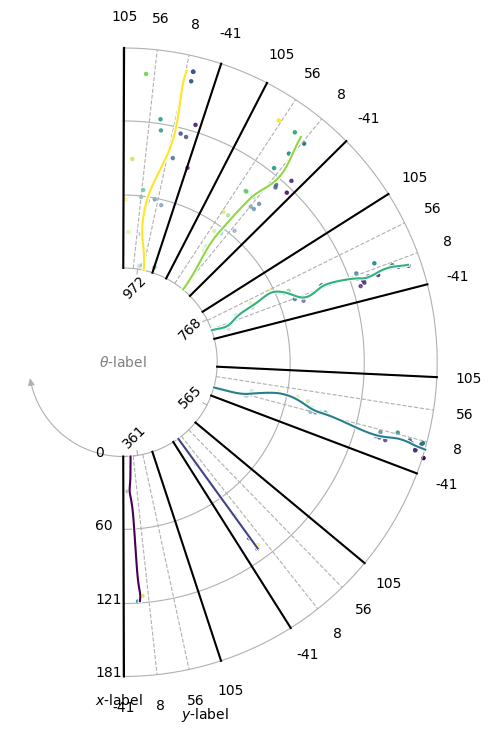

In [9]:
#init canvas (similar to `fig = plt.figure()`)
LSC = lstein.LSteinCanvas(
    thetaticks,
    xticks=xticks,                          #use as ticks and labels
    # xticks=[-20,0,20,100],                  #custom (also use as labels)
    # xticks=(xticks,["x1","x2","x3","x4"]),  #custom labels
    yticks=yticks,
    thetaguidelims=(-np.pi/2,np.pi/2), thetaplotlims=(-np.pi/2+panelsize/2,np.pi/2-panelsize/2),
    xlimdeadzone=0.3,
    thetalabel=r"$\theta$-label", xlabel=r"$x$-label", ylabel=r"$y$-label",
    thetaarrowpos_th=25, ylabpos_th=np.min(theta_raw),
    thetatickkwargs=dict(ls="-"), thetaticklabelkwargs=dict(rotation=45), thetalabelkwargs=dict(c="tab:grey"),
    xtickkwargs=dict(ls="-"), xticklabelkwargs=dict(xytext=(-2,0)), xlabelkwargs=dict(c="k"),
)

#get colors for colormapping `theta`
colors = lsu.get_colors(theta_raw)

#add different panels
for i in range(len(theta_raw)):
    
    #add a panel (similar to `ax = fig.add_subplot()`)
    LSP = LSC.add_panel(
        theta=theta_raw[i],
        yticks=None,                                                #as initialized in `LSteinCanvas`
        # yticks=yticks,                                              #predifined (use also as labels)
        # yticks=[np.floor(y_raw[i].min()), np.ceil(y_raw[i].max())], #data fills the entire panel
        # yticks=(yticks, ["A", "B", "C", "D"]),                      #predifined (custom labels)
        panelsize=panelsize,
        show_panelbounds=True, show_yticks=True,
        # y_projection_method="theta",                                #execute projection in theta-space (preferred)
        y_projection_method="y",                                    #execute projection in y-space
        ytickkwargs=dict(ls="--"), yticklabelkwargs=None,
        panelboundskwargs=None,
    )

    #add a seroes to the panel
    LSP.plot(x_raw[i], y_raw[i], seriestype="scatter", c=y_raw[i], s=5,  alpha=np.linspace(0, 1, y_raw[i].shape[0]))
    LSP.plot(x_pro[i], y_pro[i], seriestype="plot", c="w", lw=3)
    LSP.plot(x_pro[i], y_pro[i], seriestype="plot", color=colors[i])
    # LSP.plot(x_pro[i], y_pro[i], seriestype="bar", color=colors[i])

fig = lstein.draw(LSC, figsize=(5,9))
fig.tight_layout()
fig.show()

# Convenience Usage
This is a convenience wrapper similar to [matplotlibs](https://matplotlib.org/) `plt` methods.

/tmp/ipykernel_54336/2183376300.py:19: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


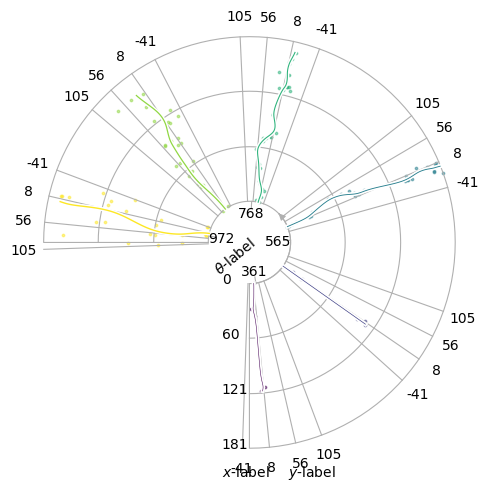

In [10]:
#init canvas (similar to `fig = plt.figure()`)
LSC = lstein.LSteinCanvas(
    thetaticks, xticks, yticks,
    thetaguidelims=(-np.pi/2,2*np.pi/2), thetaplotlims=(-np.pi/2+panelsize/2,2*np.pi/2-panelsize/2),
    xlimdeadzone=0.2,
    thetalabel=r"$\theta$-label", xlabel=r"$x$-label", ylabel=r"$y$-label",
    thetaarrowpos_th=None, ylabpos_th=np.min(theta_raw),
    thetatickkwargs=None, thetaticklabelkwargs=dict(pad=0.3), thetalabelkwargs=dict(rotation=40, textcoords="offset fontsize", xytext=(-1,-1)),
    xtickkwargs=None, xticklabelkwargs=dict(xytext=(-2,0)), xlabelkwargs=None,
)

#adding all the series (will initialize panels for you)
LSC.plot(theta_raw, x_raw, y_raw, seriestype="scatter", panel_kwargs=dict(y_projection_method="theta"), series_kwargs=dict(s=3, alpha=0.5))
LSC.plot(theta_pro, x_pro, y_pro, seriestype="plot", series_kwargs=dict(lw=3, c="w"))
LSC.plot(theta_pro, x_pro, y_pro, seriestype="plot", panel_kwargs=dict(y_projection_method="theta"), series_kwargs=[dict(lw=_/theta_pro.max(), ls="-") for _ in theta_pro])

fig = lstein.draw(LSC, figsize=(5,9))
fig.tight_layout()
fig.show()


# Customizations

## Axis Inversion
* for inversion of the x- and y-axis simply pass reverse sorted `xticks` and/or `yticks`
* for inversion of the $\theta$-axis pass the following:
    * `thetaguidelims[0] > thetaguidelims[1]`
    * `thetaplotlims[0] > thetaplotlims[1]`

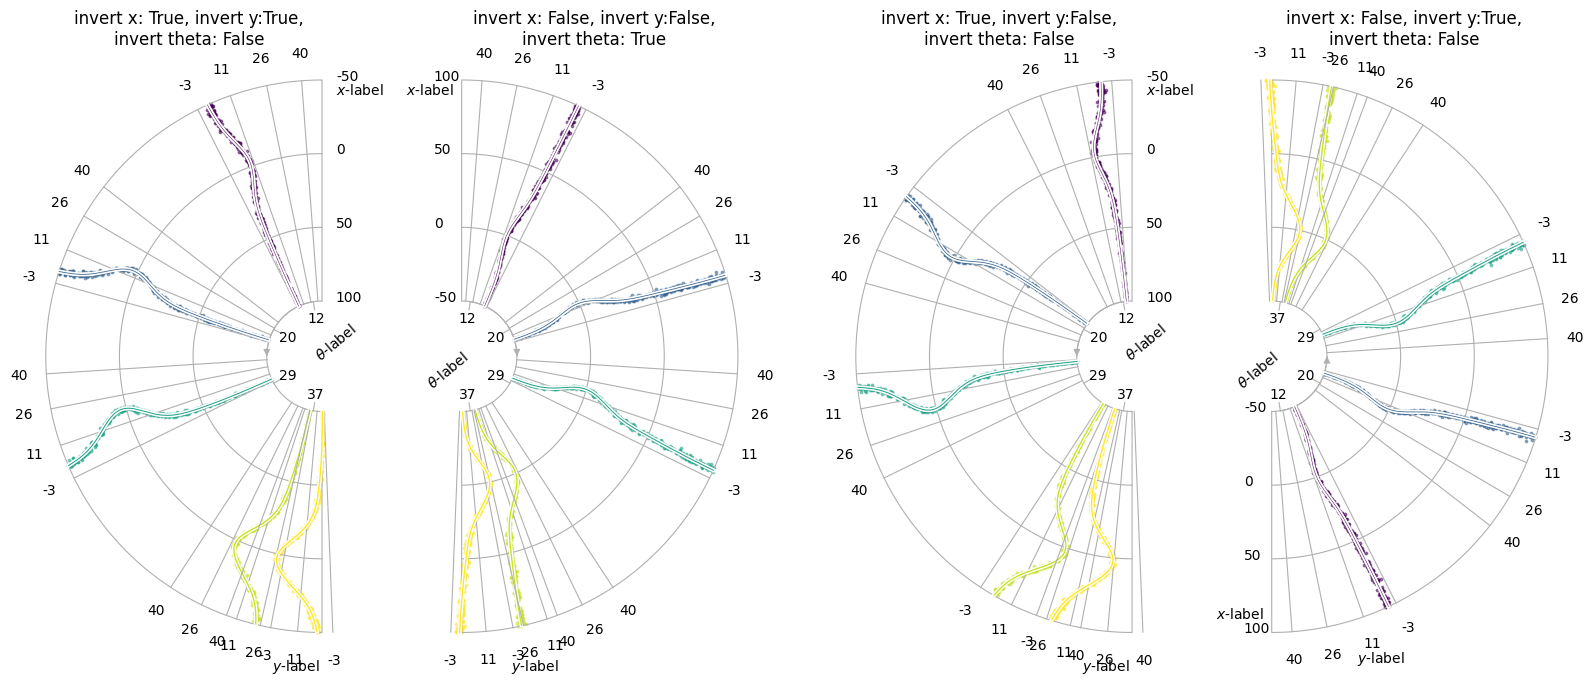

In [11]:
theta_raw, x_raw, y_raw, \
theta_pro, x_pro, y_pro, \
thetalab, xlab, ylab = gen_data("lc")

unique_thetas, \
thetaticks, xticks, yticks, \
panelsize, \
colors = get_stats(theta_raw, x_raw, y_raw)

#init canvas (similar to `fig = plt.figure()`)
##inverting x-axis and y-axis (because more readable)
LSC1 = lstein.LSteinCanvas(
    thetaticks, xticks[::-1], yticks[::-1],
    thetaguidelims=(np.pi/2,3*np.pi/2), thetaplotlims=(np.pi/2+panelsize/2,3*np.pi/2-panelsize/2),
    xlimdeadzone=0.2,
    thetalabel=r"$\theta$-label", xlabel=r"$x$-label", ylabel=r"$y$-label",
    thetaarrowpos_th=None, ylabpos_th=np.max(theta_raw),
    thetatickkwargs=None, thetaticklabelkwargs=dict(pad=0.3), thetalabelkwargs=dict(rotation=40, textcoords="offset fontsize", xytext=(1,1)),
    xtickkwargs=None, xticklabelkwargs=dict(xytext=(1,0)), xlabelkwargs=dict(xytext=(1,-1)),
)

##invesion in theta
LSC2 = lstein.LSteinCanvas(
    thetaticks, xticks, yticks,
    thetaguidelims=(np.pi/2,-np.pi/2), thetaplotlims=(np.pi/2-panelsize/2,-np.pi/2+panelsize/2),
    xlimdeadzone=0.2,
    thetalabel=r"$\theta$-label", xlabel=r"$x$-label", ylabel=r"$y$-label",
    thetaarrowpos_th=None, ylabpos_th=np.max(theta_raw),
    thetatickkwargs=None, thetaticklabelkwargs=dict(pad=0.3), thetalabelkwargs=dict(rotation=40, textcoords="offset fontsize", xytext=(-1,-1)),
    xtickkwargs=None, xticklabelkwargs=dict(xytext=(-2,0)), xlabelkwargs=dict(xytext=(-4,-1)),
)
##inverting only x-axis
LSC3 = lstein.LSteinCanvas(
    thetaticks, xticks[::-1], yticks,
    thetaguidelims=(np.pi/2,3*np.pi/2), thetaplotlims=(np.pi/2+panelsize/2,3*np.pi/2-panelsize/2),
    xlimdeadzone=0.2,
    thetalabel=r"$\theta$-label", xlabel=r"$x$-label", ylabel=r"$y$-label",
    thetaarrowpos_th=None, ylabpos_th=np.max(theta_raw),
    thetatickkwargs=None, thetaticklabelkwargs=dict(pad=0.3), thetalabelkwargs=dict(rotation=40, textcoords="offset fontsize", xytext=(1,1)),
    xtickkwargs=None, xticklabelkwargs=dict(xytext=(1,0)), xlabelkwargs=dict(xytext=(1,-1)),
)

##inverting only y-axis
LSC4 = lstein.LSteinCanvas(
    thetaticks, xticks, yticks[::-1],
    thetaguidelims=(-np.pi/2,np.pi/2), thetaplotlims=(-np.pi/2+panelsize/2,np.pi/2-panelsize/2),
    xlimdeadzone=0.2,
    thetalabel=r"$\theta$-label", xlabel=r"$x$-label", ylabel=r"$y$-label",
    thetaarrowpos_th=None, ylabpos_th=np.min(theta_raw),
    thetatickkwargs=None, thetaticklabelkwargs=dict(pad=0.3), thetalabelkwargs=dict(rotation=40, textcoords="offset fontsize", xytext=(-1,-1)),
    xtickkwargs=None, xticklabelkwargs=dict(xytext=(-2,0)), xlabelkwargs=dict(xytext=(-4,1)),
)

#plotting all the series (similar to `plt.plot()`)
LSC1.plot(theta_raw, x_raw, y_raw, seriestype="scatter", panel_kwargs=dict(y_projection_method="theta"), series_kwargs=dict(s=3, alpha=0.5))
LSC1.plot(theta_pro, x_pro, y_pro, seriestype="plot", series_kwargs=dict(lw=3, c="w"))
LSC1.plot(theta_pro, x_pro, y_pro, seriestype="plot", panel_kwargs=dict(y_projection_method="theta"), series_kwargs=[dict(lw=_/theta_pro.max(), ls="-") for _ in theta_pro])
LSC2.plot(theta_raw, x_raw, y_raw, seriestype="scatter", panel_kwargs=dict(y_projection_method="theta"), series_kwargs=dict(s=3, alpha=0.5))
LSC2.plot(theta_pro, x_pro, y_pro, seriestype="plot", series_kwargs=dict(lw=3, c="w"))
LSC2.plot(theta_pro, x_pro, y_pro, seriestype="plot", panel_kwargs=dict(y_projection_method="theta"), series_kwargs=[dict(lw=_/theta_pro.max(), ls="-") for _ in theta_pro])
LSC3.plot(theta_raw, x_raw, y_raw, seriestype="scatter", panel_kwargs=dict(y_projection_method="theta"), series_kwargs=dict(s=3, alpha=0.5))
LSC3.plot(theta_pro, x_pro, y_pro, seriestype="plot", series_kwargs=dict(lw=3, c="w"))
LSC3.plot(theta_pro, x_pro, y_pro, seriestype="plot", panel_kwargs=dict(y_projection_method="theta"), series_kwargs=[dict(lw=_/theta_pro.max(), ls="-") for _ in theta_pro])
LSC4.plot(theta_raw, x_raw, y_raw, seriestype="scatter", panel_kwargs=dict(y_projection_method="theta"), series_kwargs=dict(s=3, alpha=0.5))
LSC4.plot(theta_pro, x_pro, y_pro, seriestype="plot", series_kwargs=dict(lw=3, c="w"))
LSC4.plot(theta_pro, x_pro, y_pro, seriestype="plot", panel_kwargs=dict(y_projection_method="theta"), series_kwargs=[dict(lw=_/theta_pro.max(), ls="-") for _ in theta_pro])

fig = plt.figure(figsize=(16,9))
ax1 = fig.add_subplot(141, title="invert x: True, invert y:True,\ninvert theta: False")
ax2 = fig.add_subplot(142, title="invert x: False, invert y:False,\ninvert theta: True")
ax3 = fig.add_subplot(143, title="invert x: True, invert y:False,\ninvert theta: False")
ax4 = fig.add_subplot(144, title="invert x: False, invert y:True,\ninvert theta: False")

lstein.LSteinMPL(LSC1).show(ax1)
lstein.LSteinMPL(LSC2).show(ax2)
lstein.LSteinMPL(LSC3).show(ax3)
lstein.LSteinMPL(LSC4).show(ax4)

fig.tight_layout()
plt.show()